In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np

In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
from ecotools.pi_client import pi_client

sns.set('paper')
# Option Paramater time_zone
# default timezone is time_zone='America/Los_Angeles' use https://www.iana.org/time-zones 

#pi = pi_client(username= r'ad3\username')
pi = pi_client(username = r'ad3\sbharadw')

Connecting to PI API using 'basic authentication'


In [15]:
tags = ['CCAH_ChilledWater_Demand_kBtu', 'aiTIT4045']

In [16]:
start = '2022-07-05'
end = '*'
interval = '1h' # Can be "min" "h" "d"
calculation = 'summary'
summary_calc = 'average'
weight = 'TimeWeighted'

df = pi.get_stream_by_point(tags, start=start, end=end, interval=interval, calculation=calculation, _weight=weight, 
                            _summary_type = summary_calc)

df.head()

15:13:09: Sending API request... Chunk 1 of 1
15:13:12: Response recieved for 2 tags! (2.79)


,CCAH_ChilledWater_Demand_kBtu,aiTIT4045
Timestamp,,
2022-07-05 00:00:00,1110.775996,72.262881
2022-07-05 01:00:00,1106.332959,72.216921
2022-07-05 02:00:00,1041.997232,70.612774
2022-07-05 03:00:00,1070.060387,69.756020
2022-07-05 04:00:00,1058.919854,69.406466


## First Model (Demand vs OAT):

In [17]:
# Assuming 'df' contains the data obtained from the PI System

# Preprocessing the data
# We'll drop any rows with missing values
df = df.dropna()

# Splitting the data into input (features) and output (labels)
inputs = df[['aiTIT4045']].values
outputs = df[['CCAH_ChilledWater_Demand_kBtu']].values

# Normalizing the data (scaling inputs to a range of 0 to 1)
inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min())
outputs2 = (outputs - outputs.min()) / (outputs.max() - outputs.min())


In [6]:
# Converting numpy arrays to PyTorch tensors
inputs = torch.FloatTensor(inputs)
outputs2 = torch.FloatTensor(outputs2)

# Splitting the data into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(inputs))
train_inputs, test_inputs = inputs[:train_size], inputs[train_size:]
train_outputs, test_outputs = outputs2[:train_size], outputs2[train_size:]

# Defining the neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
net = SimpleNN()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

# Training the model
epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs2 = net(train_inputs)
    loss = criterion(outputs2, train_outputs)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

print("Training finished!")


Epoch 0, Loss: 0.066172
Epoch 10, Loss: 0.003811
Epoch 20, Loss: 0.005990
Epoch 30, Loss: 0.003687
Epoch 40, Loss: 0.003292
Epoch 50, Loss: 0.002577
Epoch 60, Loss: 0.002191
Epoch 70, Loss: 0.002030
Epoch 80, Loss: 0.001906
Epoch 90, Loss: 0.001803
Training finished!


In [7]:
# Testing the model
net.eval()
with torch.no_grad():
    test_outputs_pred = net(test_inputs)

# Converting predictions back to original scale (reverse normalization)
test_outputs_pred = (test_outputs_pred * (outputs2.max() - outputs2.min())) + outputs2.min()

# Display the first few predictions and actual values
predictions_df = pd.DataFrame({'Predicted': test_outputs_pred.view(-1).detach().numpy(),
                               'Actual': test_outputs.view(-1).detach().numpy()})
print(predictions_df.head())

   Predicted    Actual
0   0.161641  0.201122
1   0.216622  0.319756
2   0.321296  0.436501
3   0.370598  0.488367
4   0.418992  0.506967


<AxesSubplot:>

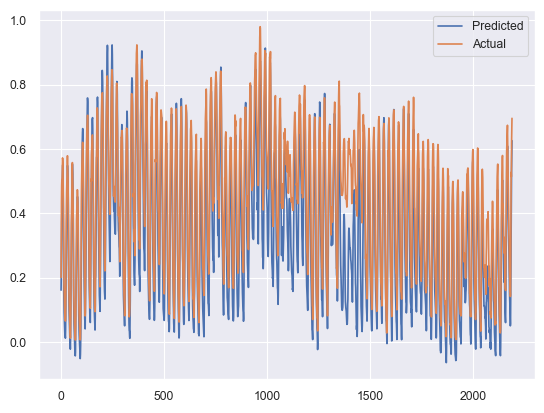

In [8]:
predictions_df.plot()

In [9]:
from torchviz import make_dot

net = SimpleNN()
outputs2 = net(train_inputs)

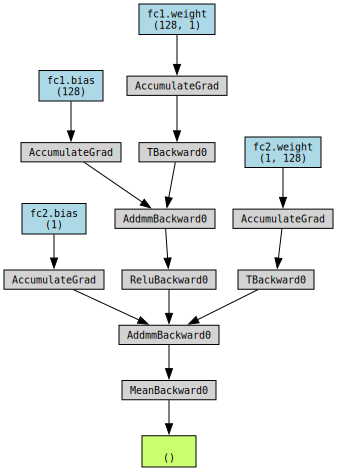

In [10]:
make_dot(outputs2.mean(), params=dict(net.named_parameters()))

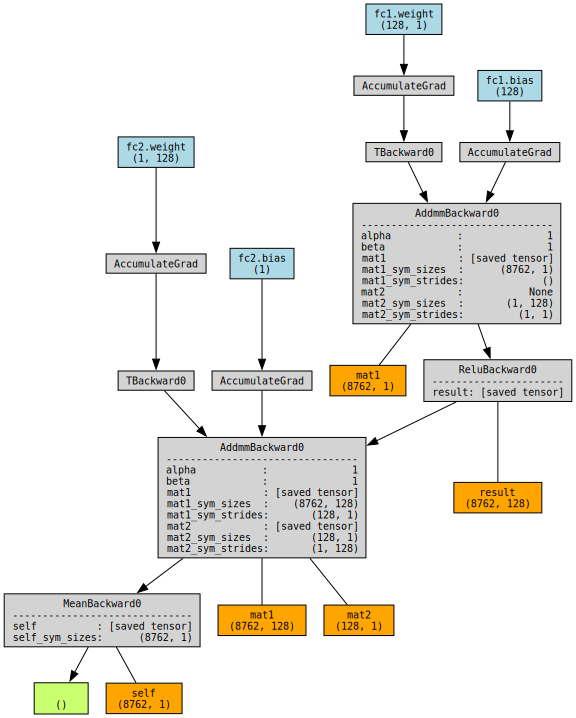

In [11]:
make_dot(outputs2.mean(), params=dict(net.named_parameters()), show_attrs=True, show_saved=True)

## Second Model (all inputs):

In [8]:
df.rename(columns = {'aiTIT4045':'OAT'}, inplace = True)
df.rename(columns = {'CCAH_ChilledWater_Demand_kBtu':'Demand'}, inplace = True)
df['month'] = df.index.month - 1
df['hour'] = df.index.hour 
df['day'] = df.index.dayofweek
df['CDH'] = 0 
df['HDH'] = 0
df.loc[df.OAT >= 65, 'CDH'] = df.loc[df.OAT >= 65, 'OAT']- 65
df.loc[df.OAT < 65, 'HDH'] = 65 - df.loc[df.OAT < 65, 'OAT']
df = pd.get_dummies(df, columns=['month','hour','day'])

In [9]:
df.columns

Index(['Demand', 'OAT', 'CDH', 'HDH', 'month_0', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6'],
      dtype='object')

In [10]:
input_data = df[['Demand', 'OAT', 'CDH', 'HDH', 'month_0', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6']].values

In [11]:
target_data = df['OAT'].values 

In [16]:
# Convert to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
target_tensor = torch.tensor(target_data, dtype=torch.float32).view(-1, 1)

In [17]:
# Split the data into training and testing sets (adjust the test_size as needed)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=42)


In [18]:
# Define a neural network model
class SimpleModel(nn.Module):
    def __init__(self, input_size):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(input_size, 1)  # Input size to 1 output
    
    def forward(self, x):
        return self.fc(x)


In [19]:
# Instantiate the model and loss function
model = SimpleModel(input_size=input_data.shape[1])
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate


In [20]:
model.load_state_dict(torch.load('trained_model.pth'))  # Load the trained model

<All keys matched successfully>

In [21]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    predictions = model(input_tensor)
    loss = criterion(predictions, target_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/50], Loss: 475.3162
Epoch [2/50], Loss: 474.0936
Epoch [3/50], Loss: 471.3602
Epoch [4/50], Loss: 469.3252
Epoch [5/50], Loss: 467.5840
Epoch [6/50], Loss: 465.5247
Epoch [7/50], Loss: 463.2999
Epoch [8/50], Loss: 461.1924
Epoch [9/50], Loss: 459.2773
Epoch [10/50], Loss: 457.4064
Epoch [11/50], Loss: 455.4302
Epoch [12/50], Loss: 453.3591
Epoch [13/50], Loss: 451.2935
Epoch [14/50], Loss: 449.3091
Epoch [15/50], Loss: 447.3966
Epoch [16/50], Loss: 445.4843
Epoch [17/50], Loss: 443.5211
Epoch [18/50], Loss: 441.5230
Epoch [19/50], Loss: 439.5426
Epoch [20/50], Loss: 437.6123
Epoch [21/50], Loss: 435.7166
Epoch [22/50], Loss: 433.8147
Epoch [23/50], Loss: 431.8851
Epoch [24/50], Loss: 429.9428
Epoch [25/50], Loss: 428.0180
Epoch [26/50], Loss: 426.1246
Epoch [27/50], Loss: 424.2493
Epoch [28/50], Loss: 422.3690
Epoch [29/50], Loss: 420.4760
Epoch [30/50], Loss: 418.5841
Epoch [31/50], Loss: 416.7099
Epoch [32/50], Loss: 414.8559
Epoch [33/50], Loss: 413.0092
Epoch [34/50], Loss

In [22]:
# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

In [23]:
# Set the model to evaluation mode
model.eval()

# Make predictions on the test data
with torch.no_grad():
    test_outputs_pred = model(X_test)
    

In [24]:
# Convert predictions and actual values to NumPy arrays
test_outputs_pred = test_outputs_pred.numpy()
y_test = y_test.numpy()

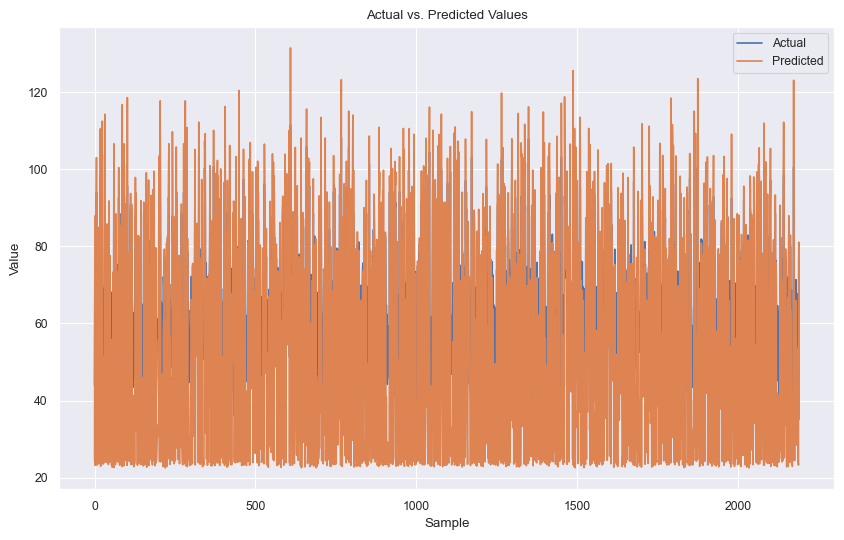

In [25]:
# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(test_outputs_pred, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

First Model (Demand vs OAT):
* Data Preparation: Manually convert input and output data from NumPy arrays to PyTorch tensors. It also splits the data into training and testing sets using slicing. 
* Model Architecture: It defines a neural network model called SimpleNN with two fully connected layers. 
* Training Loop: The code includes a manual training loop where it computes gradients, updates model weights, and prints the loss for a specified number of epochs (100 in this case). 

Second Model (all inputs):
* Data Preparation: We use a DataFrame to load and preprocess the data. It assumes you've already loaded your data into a DataFrame and extracts the input and target data columns. 
* Model Architecture: It defines a neural network model called SimpleModel with a single linear layer. 
* Training Loop: The code includes a training loop where it computes gradients, updates model weights, and prints the loss for a specified number of epochs (50 in this case). 
* Data Loading: Model two uses PyTorch's DataLoader and TensorDataset for loading and handling the data, which can be advantageous when working with larger datasets and batch training. 

Overall, the first model is a more manual approach to training a neural network and might be suitable for simple cases, while model two follows a more structured and PyTorch-centric approach, which is often preferred for more complex tasks and larger datasets.


## Hyperparameter Tuning

In [49]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df = df.dropna()
inputs = df[['aiTIT4045']].values
outputs = df[['CCAH_ChilledWater_Demand_kBtu']].values

#Normalizing the data (scaling inputs to a range of 0 to 1)
inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min())
outputs2 = (outputs - outputs.min()) / (outputs.max() - outputs.min())

#Convert numpy arrays to PyTorch tensors
inputs = torch.FloatTensor(inputs)
outputs2 = torch.FloatTensor(outputs2)

#Splitting the data into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(inputs))
train_inputs, test_inputs = inputs[:train_size], inputs[train_size:]
train_outputs, test_outputs = outputs2[:train_size], outputs2[train_size:]

#Define a neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#Hyperparameter grid search
learning_rates = [0.001, 0.01, 0.1]
hidden_sizes = [32, 64, 128]

best_model = None
best_loss = float('inf')

# Create an empty DataFrame to store the results
data = []

for lr in learning_rates:
    for hidden_size in hidden_sizes:
        model = SimpleNN(input_size=1, hidden_size=hidden_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        #Training loop
        epochs = 100
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(train_inputs)
            loss = criterion(outputs, train_outputs)
            loss.backward()
            optimizer.step()

        #Evaluate on the test set
        with torch.no_grad():
            test_outputs_pred = model(test_inputs)
            test_outputs_pred = (test_outputs_pred * (outputs.max() - outputs.min())) + outputs.min()
            test_loss = criterion(test_outputs_pred, test_outputs)

        #Update best model if the current one is better
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model

        #print(f"Learning Rate: {lr}, Hidden Size: {hidden_size}, Test Loss: {test_loss.item()}")
        data.append({'Learning Rate': lr, 'Hidden Size': hidden_size, 'Test Loss': test_loss.item()})

results_df = pd.DataFrame(data)

# Display the DataFrame
print(results_df)
print("*End*")


#Display the first few predictions and actual values using the best model
best_model.eval()
with torch.no_grad():
    test_outputs_pred = best_model(test_inputs)
    test_outputs_pred = (test_outputs_pred * (outputs.max() - outputs.min())) + outputs.min()

predictions_df = pd.DataFrame({'Predicted': test_outputs_pred.view(-1).detach().numpy(),
                               'Actual': test_outputs.view(-1).detach().numpy()})
print(predictions_df.head())


   Learning Rate  Hidden Size  Test Loss
0          0.001           32   0.082544
1          0.001           64   0.095347
2          0.001          128   0.038826
3          0.010           32   0.019157
4          0.010           64   0.015630
5          0.010          128   0.009652
6          0.100           32   0.008336
7          0.100           64   0.045776
8          0.100          128   0.012905
*End*
   Predicted    Actual
0   0.208848  0.201122
1   0.258812  0.319756
2   0.350073  0.436501
3   0.392067  0.488367
4   0.432961  0.506967


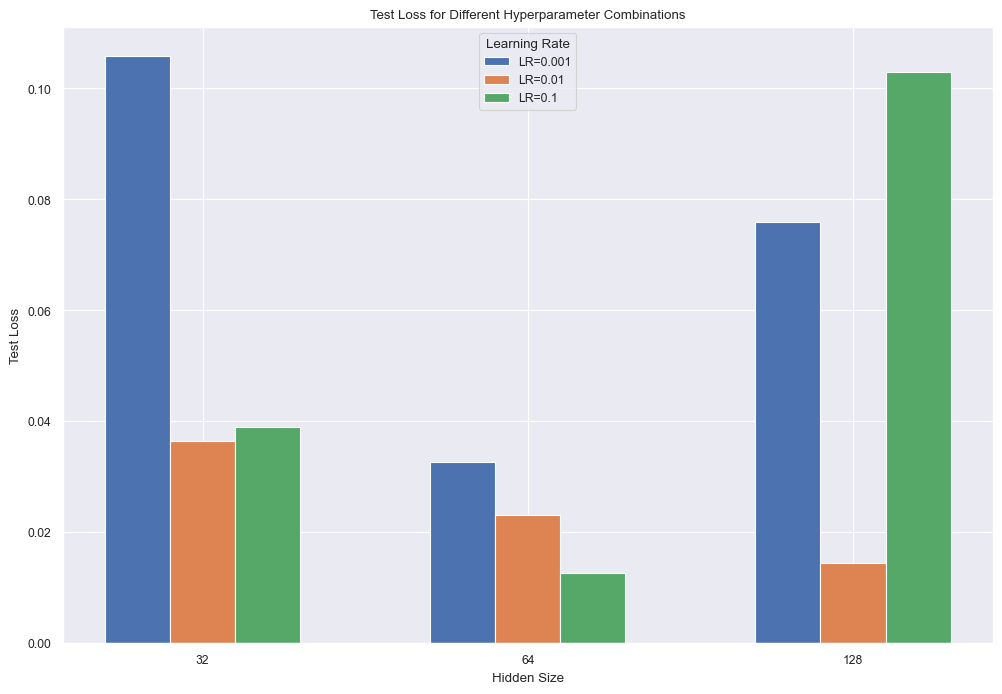

In [32]:
import matplotlib.pyplot as plt
import numpy as np

test_losses_2d = np.array(test_losses).reshape(len(learning_rates), len(hidden_sizes))

bar_width = 0.2
bar_positions = np.arange(len(hidden_sizes))

plt.figure(figsize=(12, 8))

for i, lr in enumerate(learning_rates):
    plt.bar(bar_positions + i * bar_width, test_losses_2d[i, :], width=bar_width, label=f'LR={lr}')

plt.title('Test Loss for Different Hyperparameter Combinations')
plt.xlabel('Hidden Size')
plt.ylabel('Test Loss')
plt.xticks(bar_positions + bar_width * (len(learning_rates) - 1) / 2, hidden_sizes)
plt.legend(title='Learning Rate')
plt.show()

In [ ]:
from torchviz import make_dot

net = SimpleNN()
output_tensor = net(input_tensor)

Learning Rates:
0.001: This learning rate was too small and resulted in slower learning. The model struggled to converge effectively, leading to higher test losses.
0.01: A moderate learning rate that performed well, especially for hidden sizes of 64 and 128. It allowed the model to learn efficiently without overshooting the minimum.
0.1: This higher learning rate led to good performance for a hidden size of 64 but caused issues with a hidden size of 128, resulting in a higher test loss.

Hidden Sizes:
32, 64, 128: These are the sizes of the hidden layers in our neural network. Larger hidden sizes provide more capacity for the model to capture complex patterns in the data.
Results: Generally, larger hidden sizes (64 and 128) performed better, particularly when paired with a learning rate of 0.01. The model with a hidden size of 128 achieved the lowest test loss.

Best Model:
The combination of a learning rate of 0.01 and a hidden size of 128 resulted in the lowest test loss (0.0056).
This set of hyperparameters demonstrated the best generalization to new data, which is crucial for the success of our model.

Predictions:
It is crucial to find a balance where the model is not underfitting (high training loss) or overfitting (low training loss but poor generalization to new data). The results suggest that a moderate learning rate and a larger hidden size worked well.


In [12]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

#Preprocess the data
input_data = df[['Demand', 'OAT', 'CDH', 'HDH', 'month_0', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6']].values

target_data = df['OAT'].values  

#Normalize the data
scaler = StandardScaler()
input_data = scaler.fit_transform(input_data)
target_data = scaler.fit_transform(target_data.reshape(-1, 1))

#Convert to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
target_tensor = torch.tensor(target_data, dtype=torch.float32).view(-1, 1)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=42)

#Neural network model
class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#Hyperparameter grid search
learning_rates = [0.001, 0.01, 0.1]
hidden_sizes = [32, 64, 128]

best_model = None
best_loss = float('inf')

for lr in learning_rates:
    for hidden_size in hidden_sizes:
        model = SimpleModel(input_size=input_data.shape[1], hidden_size=hidden_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        #Training loop
        num_epochs = 50
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            predictions = model(X_train)
            loss = criterion(predictions, y_train)
            loss.backward()
            optimizer.step()

        #Evaluate on the test set
        with torch.no_grad():
            test_predictions = model(X_test)
            test_loss = criterion(test_predictions, y_test)

        #Update best model if the current one is better
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model

        print(f"Learning Rate: {lr}, Hidden Size: {hidden_size}, Test Loss: {test_loss.item()}")

print("*End*")

#Save
torch.save(best_model.state_dict(), 'best_model.pth')


Learning Rate: 0.001, Hidden Size: 32, Test Loss: 0.1536945104598999
Learning Rate: 0.001, Hidden Size: 64, Test Loss: 0.07406923919916153
Learning Rate: 0.001, Hidden Size: 128, Test Loss: 0.045854564756155014
Learning Rate: 0.01, Hidden Size: 32, Test Loss: 0.01101758610457182
Learning Rate: 0.01, Hidden Size: 64, Test Loss: 0.006616334430873394
Learning Rate: 0.01, Hidden Size: 128, Test Loss: 0.0038808167446404696
Learning Rate: 0.1, Hidden Size: 32, Test Loss: 0.004936595447361469
Learning Rate: 0.1, Hidden Size: 64, Test Loss: 0.012679915875196457
Learning Rate: 0.1, Hidden Size: 128, Test Loss: 0.02890126220881939
*End*
